In [1]:
! nvidia-smi

Wed Nov 17 11:01:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    36W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import files
files.upload()

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d nizorogbezuode/rice-leaf-images

 51% 9.00M/17.7M [00:00<00:01, 8.83MB/s]
100% 17.7M/17.7M [00:00<00:00, 19.2MB/s]


In [7]:
import zipfile

unzip = zipfile.ZipFile("rice-leaf-images.zip","r")
unzip.extractall()
unzip.close()

In [8]:
# visualizing the  image
import cv2

img = cv2.imread("/content/rice_images/_BrownSpot/shape 102 .jpg")

img.shape

(256, 256, 3)

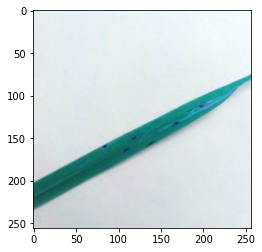

In [9]:
import matplotlib.pyplot as plt

plt.imshow(img)

##**Processing the Dataset**

In [10]:
img_dir = "/content/rice_images"

In [11]:
import tensorflow as tf

train_data = tf.keras.preprocessing.image_dataset_from_directory(img_dir,
                                                                 image_size = (224,224),
                                                                 label_mode = "categorical",
                                                                 batch_size = 64,
                                                                 validation_split = 0.2,
                                                                 shuffle = True,
                                                                 seed = 42,
                                                                 subset = "training"
                                                                 )

val_data = tf.keras.preprocessing.image_dataset_from_directory(img_dir,
                                                                image_size = (224,224),
                                                                label_mode = "categorical",
                                                                batch_size = 64,
                                                                validation_split = 0.2,
                                                                shuffle = True,
                                                                seed = 42,
                                                                subset = "validation"
                                                                )


Found 3355 files belonging to 4 classes.
Using 2684 files for training.
Found 3355 files belonging to 4 classes.
Using 671 files for validation.


In [12]:
for image, label in train_data.take(1):
  print(image.shape)
  print(label.shape)

(64, 224, 224, 3)
(64, 4)


In [13]:
label_names = train_data.class_names

label_names

['_BrownSpot', '_Healthy', '_Hispa', '_LeafBlast']

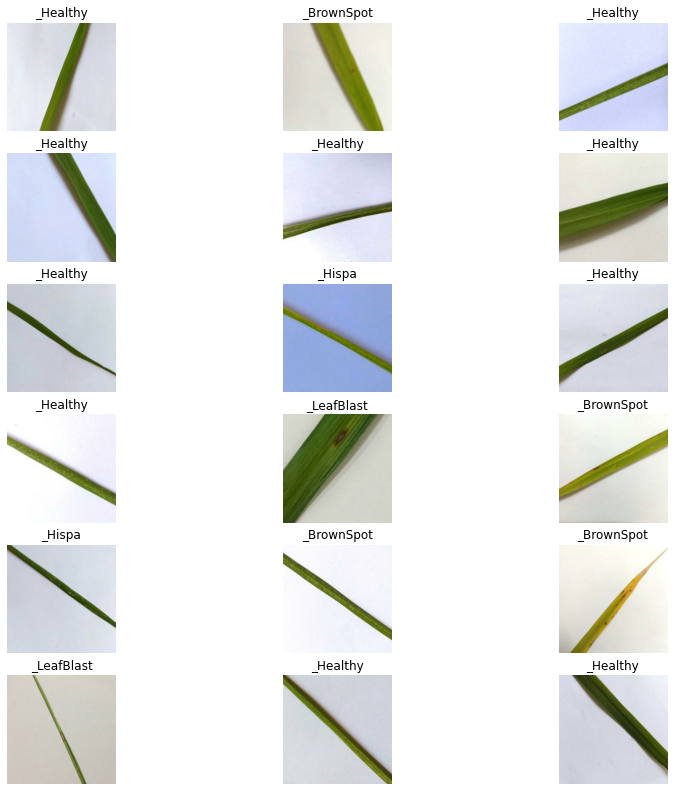

In [14]:
# visualizing the train dataset
import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(14,14))
for image, label in train_data.take(1):

  for i in range(18):
    plt.subplot(6,3,i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(label_names[tf.argmax(label[i])])
    plt.axis("off")





In [15]:
# building a effiecientnetB5 model using transfer learning

import tensorflow as tf

base_model = tf.keras.applications.EfficientNetB5(include_top= False)

base_model.trainable = False



115277824/115263384 [==============================] - 3s 0us/step


In [57]:
# building the model
import tensorflow as tf
from tensorflow.keras import layers

inputs = tf.keras.Input(shape=(224,224,3))

x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)


x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation ="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation = "relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation="relu")(x)
outputs = layers.Dense(4, activation= "softmax")(x)

eff_model = tf.keras.Model(inputs,outputs)


In [17]:
# compiling the model

eff_model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

In [18]:
# fitting the model

eff_model.fit(train_data,
          epochs = 5,
          steps_per_epoch = len(train_data),
          validation_data = val_data,
          validation_steps = len(val_data)
          )

Epoch 1/5
42/42 [==============================] - 102s 1s/step - loss: 1.1530 - accuracy: 0.5142 - val_loss: 1.0209 - val_accuracy: 0.5753
Epoch 2/5
42/42 [==============================] - 48s 1s/step - loss: 0.9812 - accuracy: 0.6107 - val_loss: 0.9383 - val_accuracy: 0.6334
Epoch 3/5
42/42 [==============================] - 48s 1s/step - loss: 0.9124 - accuracy: 0.6487 - val_loss: 0.9058 - val_accuracy: 0.6602
Epoch 4/5
42/42 [==============================] - 48s 1s/step - loss: 0.8645 - accuracy: 0.6684 - val_loss: 0.8701 - val_accuracy: 0.6811
Epoch 5/5
42/42 [==============================] - 48s 1s/step - loss: 0.8349 - accuracy: 0.6803 - val_loss: 0.8430 - val_accuracy: 0.6960


##**Tunning the Model**

In [58]:
base_model.trainable = True

for layer in base_model.layers[:-3]:
  base_model.trainable = False


eff_model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

eff_model.fit(
    train_data,
    epochs = 10,
    steps_per_epoch = len(train_data),
    validation_data = val_data,
    validation_steps = len(val_data)
)


Epoch 1/10
42/42 [==============================] - 70s 1s/step - loss: 1.1693 - accuracy: 0.5034 - val_loss: 0.9931 - val_accuracy: 0.5991
Epoch 2/10
42/42 [==============================] - 47s 1s/step - loss: 0.9507 - accuracy: 0.6170 - val_loss: 0.8935 - val_accuracy: 0.6647
Epoch 3/10
42/42 [==============================] - 47s 1s/step - loss: 0.8817 - accuracy: 0.6352 - val_loss: 0.8315 - val_accuracy: 0.6587
Epoch 4/10
42/42 [==============================] - 47s 1s/step - loss: 0.8320 - accuracy: 0.6803 - val_loss: 0.8305 - val_accuracy: 0.6766
Epoch 5/10
42/42 [==============================] - 47s 1s/step - loss: 0.8030 - accuracy: 0.6792 - val_loss: 0.8185 - val_accuracy: 0.6885
Epoch 6/10
42/42 [==============================] - 48s 1s/step - loss: 0.7846 - accuracy: 0.6926 - val_loss: 0.8431 - val_accuracy: 0.6662
Epoch 7/10
42/42 [==============================] - 47s 1s/step - loss: 0.7355 - accuracy: 0.7113 - val_loss: 0.7994 - val_accuracy: 0.6870
Epoch 8/10
42/42 [==

In [59]:
model_evaluation = eff_model.evaluate(val_data)

11/11 [==============================] - 10s 821ms/step - loss: 0.7749 - accuracy: 0.7273


In [60]:
print(f"Model Accuracy: {model_evaluation[1] *100 : 0.2f} %")

Model Accuracy:  72.73 %


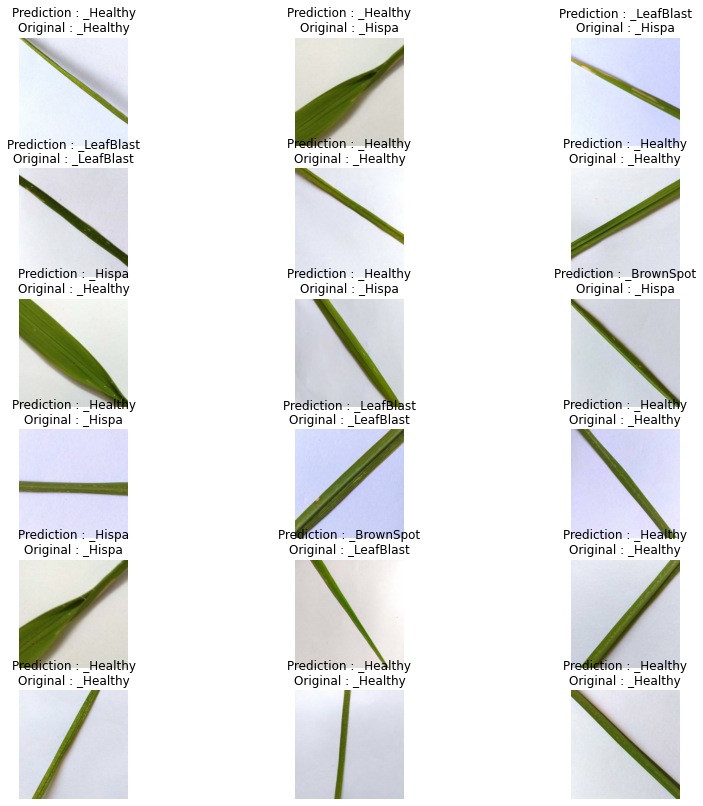

In [61]:
# visualizing the model prediction 

import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(14,14))

for image,label in val_data.take(1):
  model_prediction = eff_model.predict(image)

  for i in range(18):
    plt.subplot(6,3,i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(f"Prediction : {label_names[tf.argmax(tf.round(model_prediction[i]))]}\nOriginal : {label_names[tf.argmax(label[i])]}")
    plt.axis("off")
